# BND_M20 분석
* dataset desc : 표본코호트DB 2.2 레이아웃
* refer : mongodb/findwithpandas.ipynb
* 상병코드 검색 : https://www.koicd.kr/kcd/kcd.do

- Join Collection NSC2_BND_M20
- 고혈압 환자 대상 분석(설명 변수 5개 이상)
- 상병 코드 SICK_SYM1=SICK_SYM2=I10

- 발표 주요 내용 
+ 분석 목적
+ 변수 선택 이유(DDA, 표) : 변수명, 변수타입, 설명, 선택 이유
+ 일부 시각화(EDA)
+ 분석 스토리(CDA 중심, 표) : 변수명, 분석자, pvalue, 성립 가설
- 발표자 2명

In [33]:
import pymongo as mg
import pandas as pd
import re

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import numpy as np

In [35]:
client = mg.MongoClient(host='mongodb://localhost:27017')
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [36]:
database = client['db_NHIS']
database

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'db_NHIS')

In [37]:
collection = database['NSC2_BND_M20']
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'db_NHIS'), 'NSC2_BND_M20')

In [38]:
cursor = collection.find({})
list_cursor = list(cursor)

In [39]:
df_BND_M20=pd.DataFrame(list_cursor)
df_BND_M20[:2]

,_id,RN_INDI,BTH_YYYY,DTH_YYYYMM,COD1,COD2,RN_KEY,RN_INST,MDCARE_STRT_DT,FORM_CD,...,OPRTN_YN,MDCARE_DD_CNT,VSHSP_DD_CNT,TOT_PRSC_DD_CNT,MCARE_RSLT_TYPE,EDC_ADD_RT,ED_RC_TOT_AMT,EDC_SBA,EDC_INSUR_BRDN_AMT,STD_YYYY
0,64e6b7f1f4500c263e561efd,294364,1921LE,200707.0,T08-T14,W00-W19,2002080298703,26452,20020830,3,...,0,1,1,3,5.0,0.15,10590,3000,7590,2002
1,64e6b7f1f4500c263e561efe,294364,1921LE,200707.0,T08-T14,W00-W19,2002090466395,63715,20020910,3,...,0,1,1,2,5.0,0.15,16520,4950,11570,2002


In [40]:
df_BND_M20.to_csv("./NSC2_BND_M20.csv")

In [41]:
# 정규표현식 패턴
pattern = re.compile("^I10")

# 상병 코드가 I10로 시작하는 레코드
query = {
    "SICK_SYM1":{"$regex": pattern}
}

# 쿼리 실행
find_cursor = collection.find(query)
data = list(find_cursor)

# 결과를 DataFrame으로 변환
df_I10 = pd.DataFrame(data)
df_I10[:2]

,_id,RN_INDI,BTH_YYYY,DTH_YYYYMM,COD1,COD2,RN_KEY,RN_INST,MDCARE_STRT_DT,FORM_CD,...,OPRTN_YN,MDCARE_DD_CNT,VSHSP_DD_CNT,TOT_PRSC_DD_CNT,MCARE_RSLT_TYPE,EDC_ADD_RT,ED_RC_TOT_AMT,EDC_SBA,EDC_INSUR_BRDN_AMT,STD_YYYY
0,64e6b7f1f4500c263e561f8a,294364,1921LE,200707.0,T08-T14,W00-W19,2014112314919,16116,20141103,3,...,0,1,1,30,1.0,0.15,11830,3500,8330,2014
1,64e6b7f1f4500c263e561f8b,294364,1921LE,200707.0,T08-T14,W00-W19,2014120565697,16116,20141201,3,...,0,1,1,30,1.0,0.15,11830,3500,8330,2014


In [42]:
df_I10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8427 entries, 0 to 8426
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 8427 non-null   object 
 1   RN_INDI             8427 non-null   int64  
 2   BTH_YYYY            8427 non-null   object 
 3   DTH_YYYYMM          690 non-null    float64
 4   COD1                519 non-null    object 
 5   COD2                50 non-null     object 
 6   RN_KEY              8427 non-null   int64  
 7   RN_INST             8427 non-null   int64  
 8   MDCARE_STRT_DT      8427 non-null   int64  
 9   FORM_CD             8427 non-null   int64  
 10  MCARE_SUBJ_CD       8427 non-null   int64  
 11  SICK_SYM1           8427 non-null   object 
 12  OFIJ_TYPE           8320 non-null   object 
 13  OPRTN_YN            8427 non-null   int64  
 14  MDCARE_DD_CNT       8427 non-null   int64  
 15  VSHSP_DD_CNT        8427 non-null   int64  
 16  TOT_PR

In [43]:
df_I10.value_counts('RN_INST')

RN_INST
68317     170
31864     140
33917     128
135217    126
104156    120
         ... 
83240       1
23796       1
83330       1
114539      1
56181       1
Length: 501, dtype: int64

### 상관관계 확인
#### 목표변수
- 'ED_RC_TOT_AMT' 심결요양급여비용총액(심결본인부담금+심결보험자부담금)
- 분포 : unbalanced

#### 제외할 변수
- _id, RN_INDI, RN_KEY, RN_INST => 고유번호 
- sick_sym1  은 모두 i10이므로 
- COD1, COD2 레코드 수 너무 적어서
- BTH_YYYY 기준년도-출생년도+1 -> 나이로 환산
- DTH_YYYYMM 사망연월-출생년도+1 -> 나이로 환산(사망시 나이) 

#### 설명변수(연속형)
- STD_YYYY 기준년도
- AGE 기준년도 나이 또는 사망나이
- MDCARE_STRT_DT 요양개시일자 -> 연도로 환산
- MDCARE_DD_CNT 요양일수
- VSHSP_DD_CNT 입내원일수
- TOT_PRSC_DD_CNT 총처방일수
- EDC_ADD_RT 심결가산율

#### 설명변수(범주형)
- MCARE_RSLT_TYPE 진료결과구분
- FORM_CD 서식코드
- MCARE_SUBJ_CD 진료과목코드
- OFIJ_TYPE 공상 등 구분
- OPRTN_YN 수술여부

#### 분석 스토리 : 

In [44]:
df_I10.columns

Index(['_id', 'RN_INDI', 'BTH_YYYY', 'DTH_YYYYMM', 'COD1', 'COD2', 'RN_KEY',
       'RN_INST', 'MDCARE_STRT_DT', 'FORM_CD', 'MCARE_SUBJ_CD', 'SICK_SYM1',
       'OFIJ_TYPE', 'OPRTN_YN', 'MDCARE_DD_CNT', 'VSHSP_DD_CNT',
       'TOT_PRSC_DD_CNT', 'MCARE_RSLT_TYPE', 'EDC_ADD_RT', 'ED_RC_TOT_AMT',
       'EDC_SBA', 'EDC_INSUR_BRDN_AMT', 'STD_YYYY'],
      dtype='object')

In [45]:
# 분석에 필요한 column 추리기 
df_I10=df_I10[['STD_YYYY','BTH_YYYY','DTH_YYYYMM','MDCARE_STRT_DT','MDCARE_DD_CNT','TOT_PRSC_DD_CNT','EDC_ADD_RT',
               'MCARE_RSLT_TYPE','FORM_CD','MCARE_SUBJ_CD','OFIJ_TYPE', 'ED_RC_TOT_AMT']]

In [46]:
df_I10[:2]

,STD_YYYY,BTH_YYYY,DTH_YYYYMM,MDCARE_STRT_DT,MDCARE_DD_CNT,TOT_PRSC_DD_CNT,EDC_ADD_RT,MCARE_RSLT_TYPE,FORM_CD,MCARE_SUBJ_CD,OFIJ_TYPE,ED_RC_TOT_AMT
0,2014,1921LE,200707.0,20141103,1,30,0.15,1.0,3,1,0,11830
1,2014,1921LE,200707.0,20141201,1,30,0.15,1.0,3,1,0,11830


In [47]:
df_I10.describe()

,STD_YYYY,DTH_YYYYMM,MDCARE_STRT_DT,MDCARE_DD_CNT,TOT_PRSC_DD_CNT,EDC_ADD_RT,MCARE_RSLT_TYPE,FORM_CD,MCARE_SUBJ_CD,ED_RC_TOT_AMT
count,8427.000000,690.000000,8.427000e+03,8427.000000,8427.000000,8427.000000,7638.000000,8427.000000,8427.000000,8.427000e+03
mean,2009.655037,201645.766667,2.009723e+07,2.018275,32.653495,0.143311,1.547395,3.459594,2.203157,1.565777e+04
std,3.623154,320.048340,3.622697e+04,5.790790,20.024428,0.055137,1.475315,1.451281,4.810856,4.939590e+04
min,2002.000000,200707.000000,2.002010e+07,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000e+00
25%,2007.000000,201508.000000,2.007070e+07,1.000000,30.000000,0.150000,1.000000,3.000000,1.000000,9.430000e+03
50%,2010.000000,201602.000000,2.010070e+07,1.000000,30.000000,0.150000,1.000000,3.000000,1.000000,1.059000e+04
75%,2013.000000,201910.000000,2.013031e+07,1.000000,30.000000,0.150000,1.000000,3.000000,1.000000,1.228000e+04
max,2015.000000,202102.000000,2.015123e+07,90.000000,190.000000,0.300000,9.000000,8.000000,24.000000,2.138690e+06


In [48]:
df_I10.describe(include=object)

,BTH_YYYY,OFIJ_TYPE
count,8427,8320
unique,69,2
top,2001,0
freq,413,8317


In [49]:
df_I10.dtypes

STD_YYYY             int64
BTH_YYYY            object
DTH_YYYYMM         float64
MDCARE_STRT_DT       int64
MDCARE_DD_CNT        int64
TOT_PRSC_DD_CNT      int64
EDC_ADD_RT         float64
MCARE_RSLT_TYPE    float64
FORM_CD              int64
MCARE_SUBJ_CD        int64
OFIJ_TYPE           object
ED_RC_TOT_AMT        int64
dtype: object

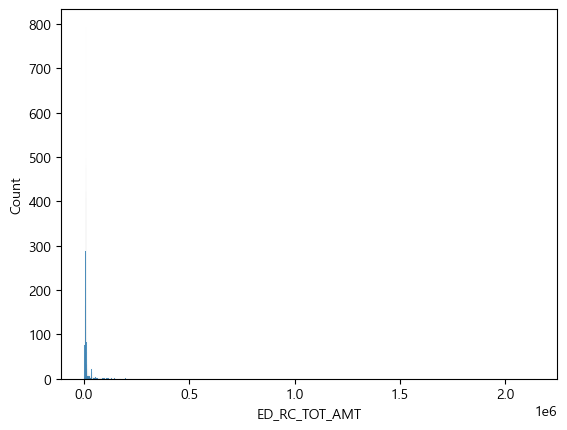

In [50]:
# 데이터 타입과 분포

sns.histplot(data=df_I10, x='ED_RC_TOT_AMT')
plt.show()

In [51]:
columns_to_convert = ['STD_YYYY', 'BTH_YYYY', 'DTH_YYYYMM', 'MDCARE_STRT_DT', 'MDCARE_DD_CNT', 'MCARE_RSLT_TYPE', 'MCARE_SUBJ_CD']
for col in columns_to_convert:
    df_I10[col] = df_I10[col].astype(str)
df_I10.dtypes

STD_YYYY            object
BTH_YYYY            object
DTH_YYYYMM          object
MDCARE_STRT_DT      object
MDCARE_DD_CNT       object
TOT_PRSC_DD_CNT      int64
EDC_ADD_RT         float64
MCARE_RSLT_TYPE     object
FORM_CD              int64
MCARE_SUBJ_CD       object
OFIJ_TYPE           object
ED_RC_TOT_AMT        int64
dtype: object

In [52]:
def remove_le(cell_value):
    if cell_value.endswith("LE"):
        return cell_value[:-2]
    else:
        return cell_value
    
df_I10['BTH_YYYY']=df_I10['BTH_YYYY'].apply(remove_le)

In [53]:
def years_only(cell_value):
    if cell_value == 'nan':
        return 0
    else:
        return cell_value[:4]
    
df_I10['DTH_YYYYMM']=df_I10['DTH_YYYYMM'].apply(years_only)
df_I10['MDCARE_STRT_DT']=df_I10['MDCARE_STRT_DT'].apply(years_only)

In [54]:
df_I10[['STD_YYYY', 'BTH_YYYY', 'DTH_YYYYMM', 'MDCARE_STRT_DT', 'MDCARE_DD_CNT', 'MCARE_RSLT_TYPE', 'MCARE_SUBJ_CD']]

,STD_YYYY,BTH_YYYY,DTH_YYYYMM,MDCARE_STRT_DT,MDCARE_DD_CNT,MCARE_RSLT_TYPE,MCARE_SUBJ_CD
0,2014,1921,2007,2014,1,1.0,1
1,2014,1921,2007,2014,1,1.0,1
2,2015,1921,2007,2015,1,1.0,1
3,2015,1921,2007,2015,1,1.0,1
4,2015,1921,2007,2015,1,1.0,1
...,...,...,...,...,...,...,...
8422,2005,2005,0,2005,1,1.0,1
8423,2005,2005,0,2005,1,1.0,1
8424,2005,2005,0,2005,1,1.0,1
8425,2006,2005,0,2006,1,1.0,1


In [55]:
columns_to_convert = ['STD_YYYY', 'BTH_YYYY', 'DTH_YYYYMM', 'MDCARE_STRT_DT']
for col in columns_to_convert:
    df_I10[col] = df_I10[col].astype(int)
df_I10.dtypes

STD_YYYY             int32
BTH_YYYY             int32
DTH_YYYYMM           int32
MDCARE_STRT_DT       int32
MDCARE_DD_CNT       object
TOT_PRSC_DD_CNT      int64
EDC_ADD_RT         float64
MCARE_RSLT_TYPE     object
FORM_CD              int64
MCARE_SUBJ_CD       object
OFIJ_TYPE           object
ED_RC_TOT_AMT        int64
dtype: object

In [56]:
def calculate_age(row):
    if row['DTH_YYYYMM'] == 0:
        return row['STD_YYYY'] - row['BTH_YYYY'] + 1
    else:
        return row['DTH_YYYYMM'] - row['BTH_YYYY'] + 1

df_I10['AGE'] = df_I10.apply(calculate_age, axis=1)

# 분석에 필요한 column 추리기 
df_I10=df_I10[['STD_YYYY', 'AGE', 'MDCARE_STRT_DT','MDCARE_DD_CNT','TOT_PRSC_DD_CNT','EDC_ADD_RT',\
               'FORM_CD','MCARE_SUBJ_CD','OFIJ_TYPE','MCARE_RSLT_TYPE', 'ED_RC_TOT_AMT']]
df_I10

,STD_YYYY,AGE,MDCARE_STRT_DT,MDCARE_DD_CNT,TOT_PRSC_DD_CNT,EDC_ADD_RT,FORM_CD,MCARE_SUBJ_CD,OFIJ_TYPE,MCARE_RSLT_TYPE,ED_RC_TOT_AMT
0,2014,87,2014,1,30,0.15,3,1,0,1.0,11830
1,2014,87,2014,1,30,0.15,3,1,0,1.0,11830
2,2015,87,2015,1,90,0.15,3,1,0,1.0,13990
3,2015,87,2015,1,90,0.15,3,1,0,1.0,13990
4,2015,87,2015,1,90,0.15,3,1,0,1.0,11800
...,...,...,...,...,...,...,...,...,...,...,...
8422,2005,1,2005,1,30,0.15,3,1,0,1.0,9050
8423,2005,1,2005,1,30,0.15,3,1,0,1.0,9050
8424,2005,1,2005,1,30,0.15,3,1,0,1.0,9050
8425,2006,2,2006,1,30,0.15,3,1,0,1.0,9380


In [57]:
df_I10=df_I10.dropna()
df_I10.isnull().sum()

STD_YYYY           0
AGE                0
MDCARE_STRT_DT     0
MDCARE_DD_CNT      0
TOT_PRSC_DD_CNT    0
EDC_ADD_RT         0
FORM_CD            0
MCARE_SUBJ_CD      0
OFIJ_TYPE          0
MCARE_RSLT_TYPE    0
ED_RC_TOT_AMT      0
dtype: int64

In [58]:
df_I10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8320 entries, 0 to 8426
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STD_YYYY         8320 non-null   int32  
 1   AGE              8320 non-null   int64  
 2   MDCARE_STRT_DT   8320 non-null   int32  
 3   MDCARE_DD_CNT    8320 non-null   object 
 4   TOT_PRSC_DD_CNT  8320 non-null   int64  
 5   EDC_ADD_RT       8320 non-null   float64
 6   FORM_CD          8320 non-null   int64  
 7   MCARE_SUBJ_CD    8320 non-null   object 
 8   OFIJ_TYPE        8320 non-null   object 
 9   MCARE_RSLT_TYPE  8320 non-null   object 
 10  ED_RC_TOT_AMT    8320 non-null   int64  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 715.0+ KB


In [59]:
list_cons=df_I10.describe().columns.to_list()
list_cons

['STD_YYYY',
 'AGE',
 'MDCARE_STRT_DT',
 'TOT_PRSC_DD_CNT',
 'EDC_ADD_RT',
 'FORM_CD',
 'ED_RC_TOT_AMT']

In [60]:
list_cate=df_I10.describe(include=object).columns.to_list()
list_cate

['MDCARE_DD_CNT', 'MCARE_SUBJ_CD', 'OFIJ_TYPE', 'MCARE_RSLT_TYPE']

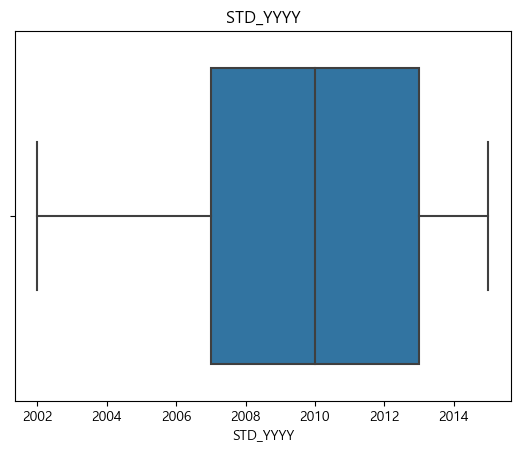

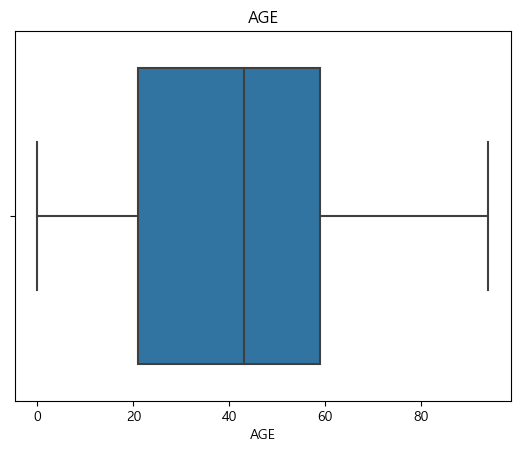

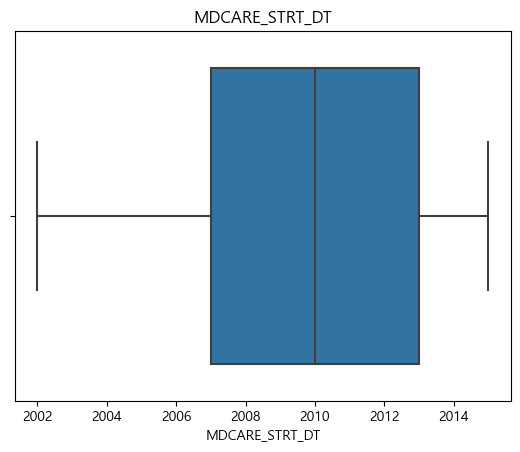

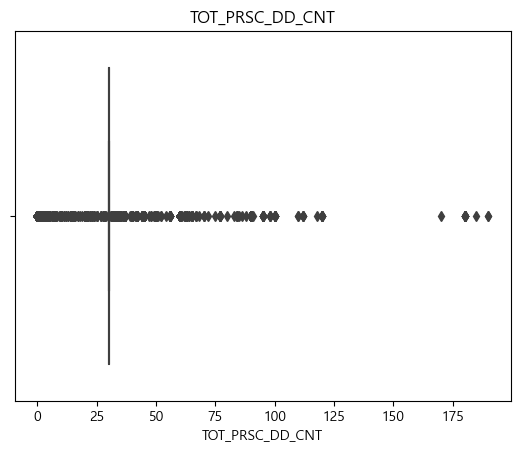

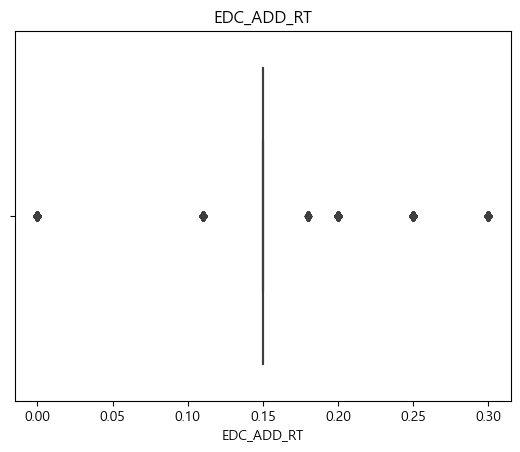

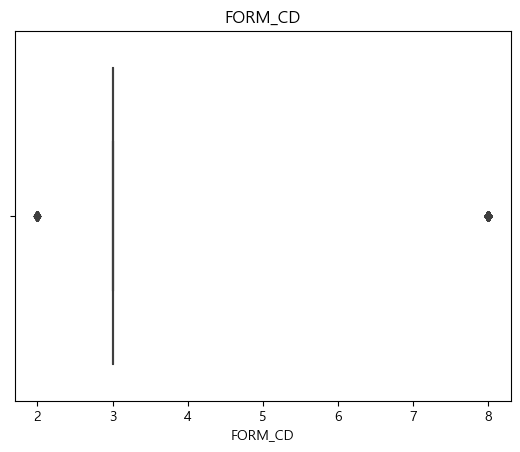

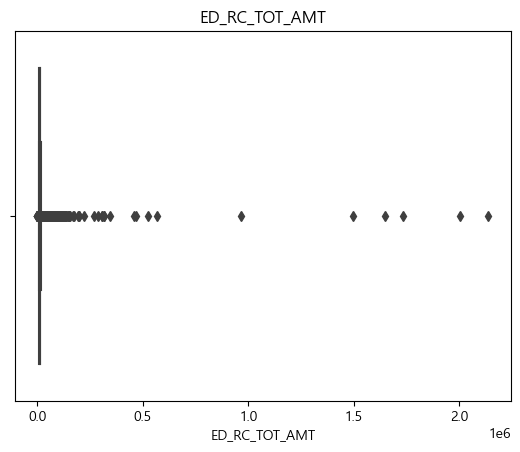

In [61]:
for item in list_cons :
    sns.boxplot(df_I10, x=item)
    plt.title(item)
    plt.show()

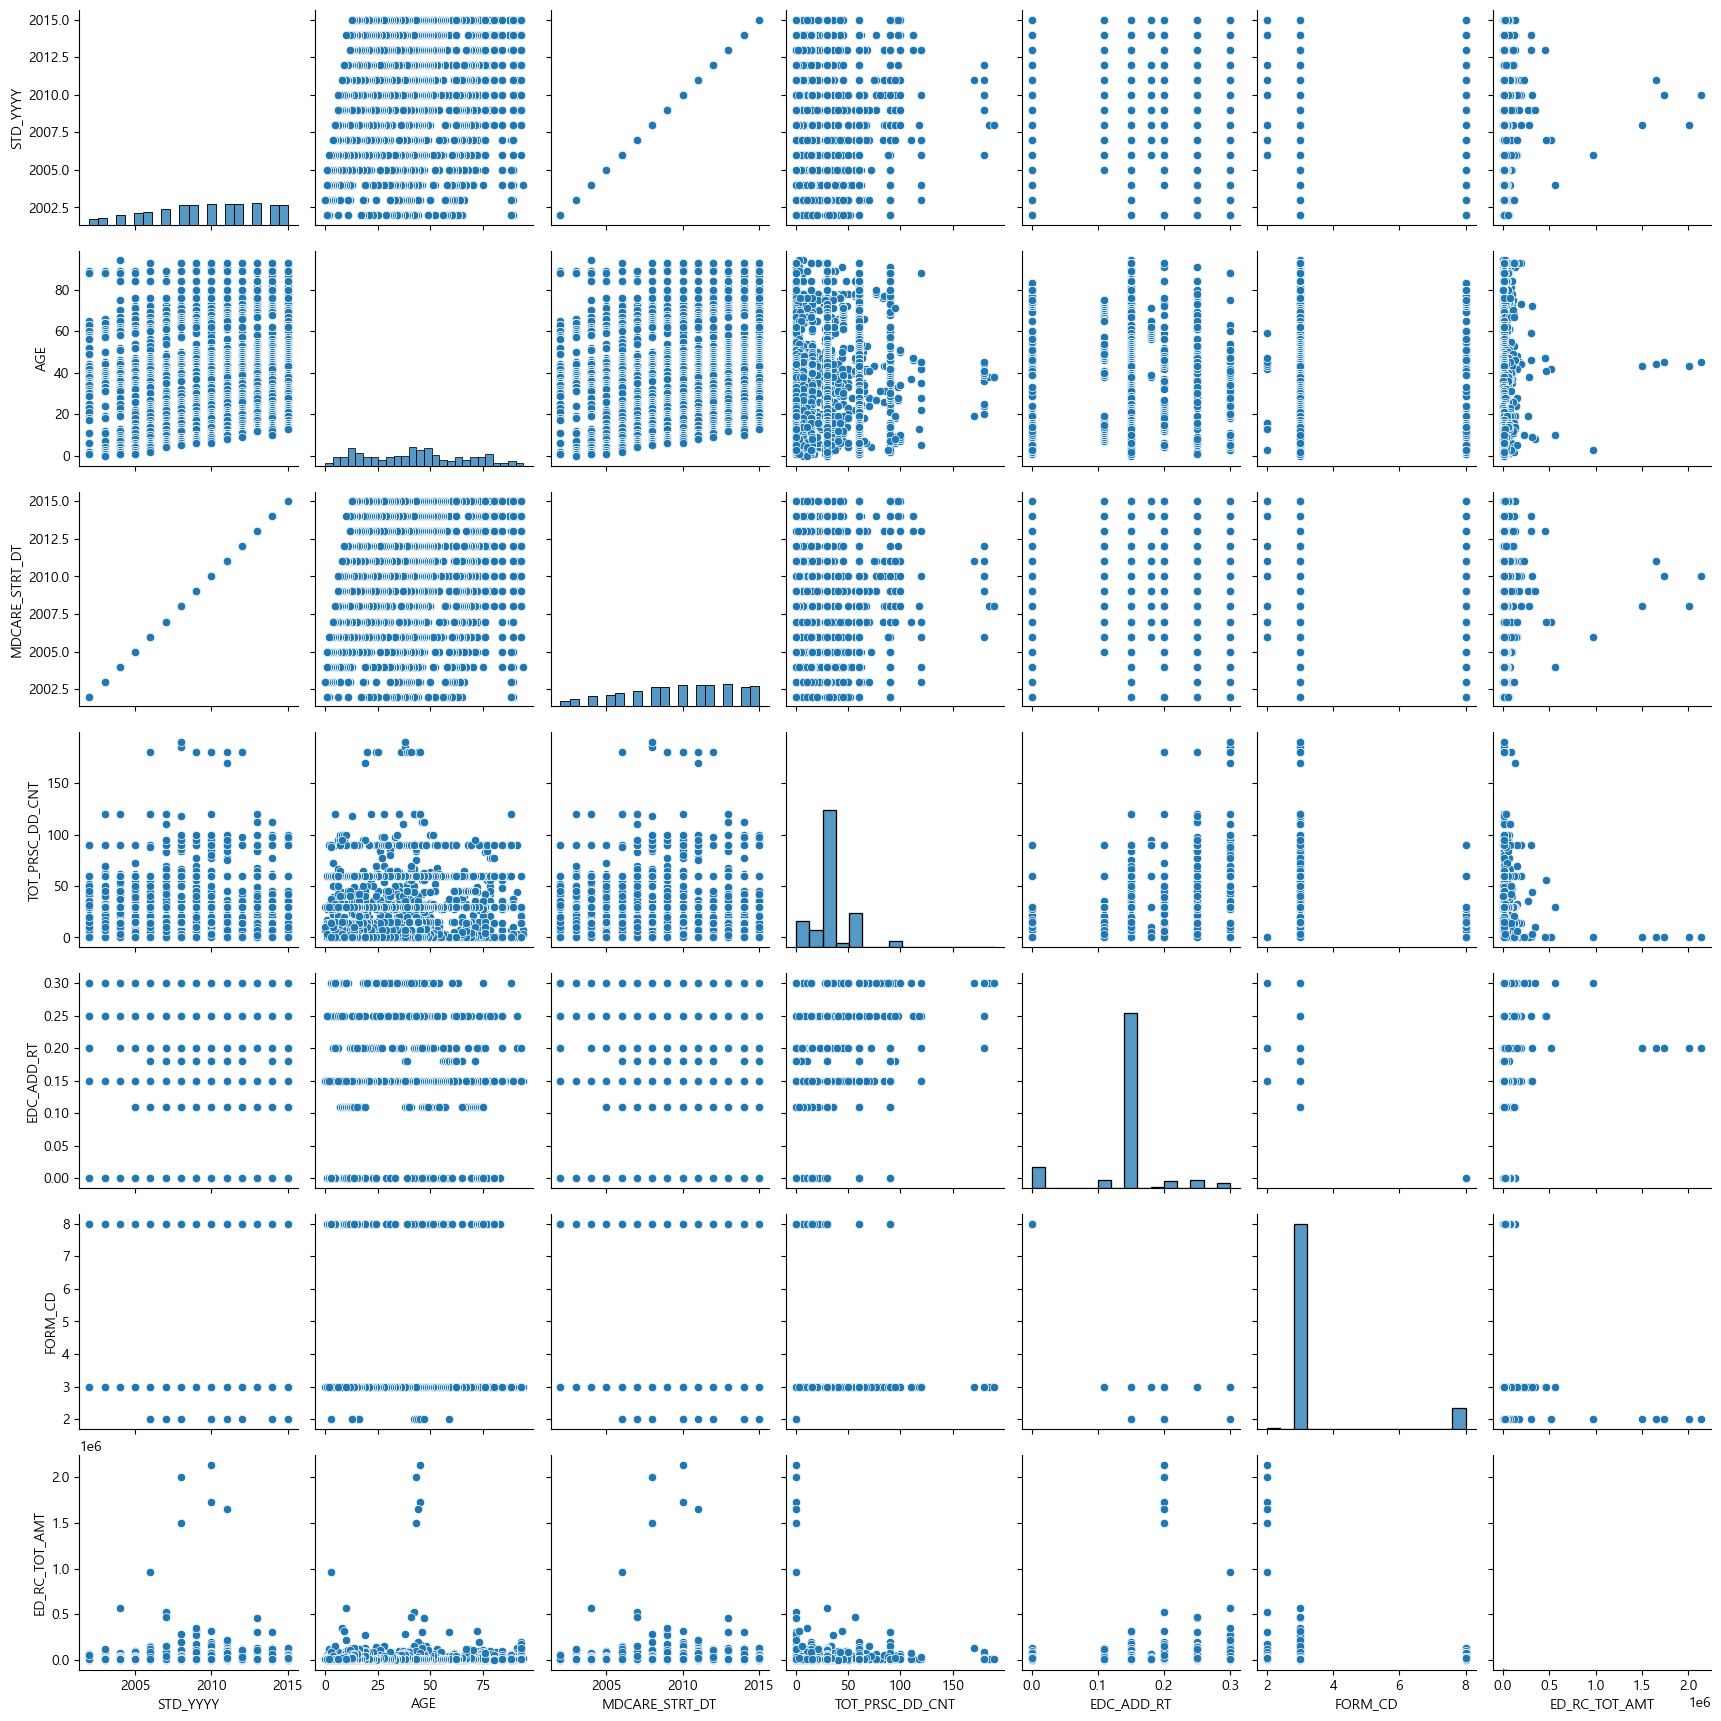

In [62]:
sns.pairplot(data=df_I10[['STD_YYYY','AGE', 'MDCARE_STRT_DT', 'TOT_PRSC_DD_CNT', 'EDC_ADD_RT', 'FORM_CD', 'ED_RC_TOT_AMT']])

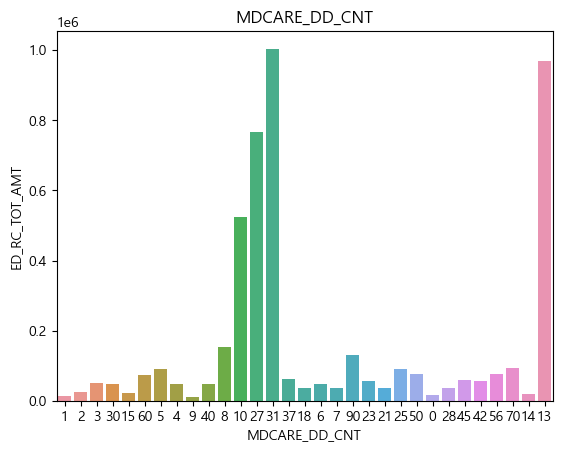

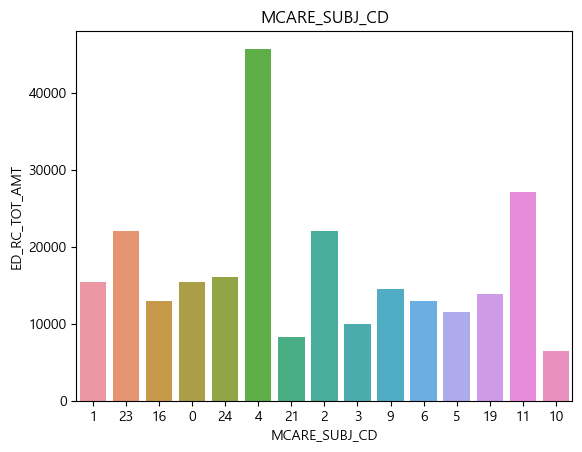

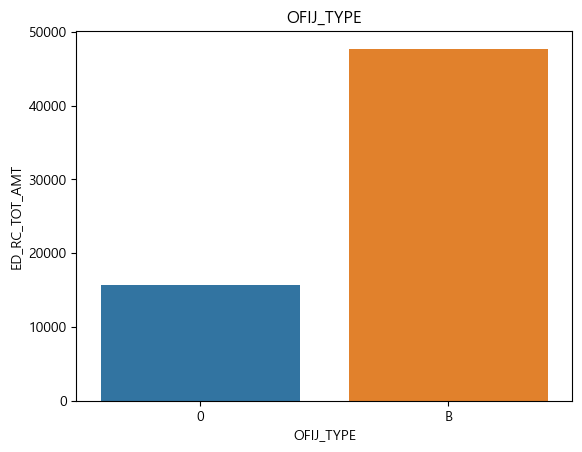

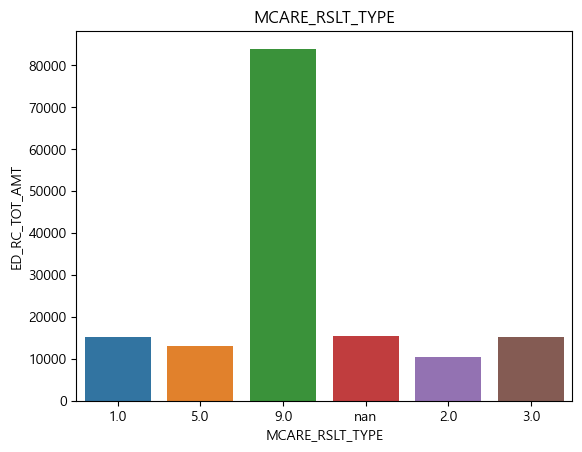

In [63]:
for item in list_cate :
    sns.barplot(data=df_I10, x=item, y='ED_RC_TOT_AMT', errorbar=None)
    plt.title(item)
    plt.show()